In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


해당 코드는 theAIGuysCode의 github repository를 참고하여 제작되었습니다.

링크: https://github.com/theAIGuysCode/YOLOv4-Cloud-Tutorial

In [2]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import os
import matplotlib.pyplot as plt
from google.colab import files

%matplotlib inline

In [3]:
#set your custom cfg to test mode 
%cd /content/drive/MyDrive/알파코 캠퍼스 /팀플 1조 (객체인식) /안홍민/yolo4/darknet/cfg
!sed -i 's/batch=64/batch=1/' yolov4-custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-custom.cfg
%cd ..

[Errno 2] No such file or directory: '/content/drive/MyDrive/알파코 캠퍼스 /팀플 1조 (객체인식) /안홍민/yolo4/darknet/cfg'
/content
sed: can't read yolov4-custom.cfg: No such file or directory
sed: can't read yolov4-custom.cfg: No such file or directory
/


In [ ]:
# 마스크 데이터 출력 확인

%cat /content/drive/MyDrive/yolov4/darknet/data/eyes_data.data

classes = 2
train = data/train.txt
valid = data/valid.txt
test = data/test.txt
names = data/ClassNames.names
backup = backup/

In [ ]:
%cd /content/drive/MyDrive/알파코 캠퍼스 /팀플 1조 (객체인식) /안홍민/yolo4/darknet

/content/drive/MyDrive/알파코 캠퍼스 /팀플 1조 (객체인식) /안홍민/yolo4/darknet


In [ ]:
# GPU, OPENCV, LIBSO을 true로 설정
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

In [ ]:
# 위의 변경된 옵션으로 makefile을 컴파일하면 darknet.py 사용이 가능해진다.
!make

In [ ]:
from darknet import *

In [ ]:
# YOLOv4 모델을 로드하여보자.
# 커스텀 모델을 사용할 경우 load_network의 1번째, 3번째 인자를 수정해야 한다.
network, class_names, class_colors = load_network("cfg/yolov4-custom.cfg", "data/eyes_data.data", "data/yolov4-custom_last.weights")

In [ ]:
# 네트워크의 width와 height을 계산
width = network_width(network)
height = network_height(network)

print(width, height)

In [ ]:
class_colors['Opened_Eye']

`cv2.cvtColor(BGR이미지, cv2.COLOR_BGR2RGB)`

* 컬러 사진을 OpenCV에서는 BGR 순서로 인식하지만 일반적으로 matplotlib 등에서 사진을 출력하기 위하여는 이미지가 RGB 순서로 저장되어 있어야 한다.
* 따라서, 위와 같은 이유등을 위하여 이미지 순서를 RGB로 변환할 때 cvtColor을 사용한다.

`cv2.resize(이미지, dsize, fx, fy, interplolation)`
* 이미지의 크기를 조정한다.
* dsize는 결과 영상의 크기를 나타내며 (width, height)의 튜플 형태를 띈다.
* dsize가 (0,0)일 경우 fx와 fy를 통해 크기를 조정한다. fx와 fy는 스케일 비율을 나타낸다.
* interpolation은 보간법을 지정한다. 보간법은 이미지 확대 또는 축소 과정에서 이미지 픽셀의 유실이 일어났을 때, 주변 픽셀값을 이용하여 이를 채워넣는 방법을 의미한다. cv2.INTER_NEAREST,cv2.INTER_LINEAR, cv2.INTER_CUBIC 등이 있으며, INTER_LINEAR의 방법이 속도가 빠를 뿐더러 성능이 좋기 때문에 가장 많이 사용된다.

In [ ]:
# object detection을 수행하는 darknet_helper 함수를 살펴보자.

def darknet_helper(img, width, height):
  # 이미지를 darknet style로 전처리 -> darknet_image 변수에 저장
  darknet_image = make_image(width, height, 3)
  # input image를 BRG에서 RGB 순서로 변환
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # input image의 size를 512x512로 변환 (network에서 받아들이는 이미지의 크기가 512x512였기 때문에)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # bounding box의 크기를 조정하기 위하여 이미지 크기 비율을 계산 
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width # 원본 이미지 width/ network width
  height_ratio = img_height/height # 원본 이미지 height/ network height

  # darknet stlye로 전처리된 이미지로 모델을 작동시켜 detection을 수행
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  # detect_image 함수 실행
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)

  return detections, width_ratio, height_ratio

`matplotlib.pyplot.imshow(RGB 데이터 또는 2d scalaer 데이터)`

* imread() 함수를 사용하여 jpg 등 이미지 파일을 읽어온 후, imshow() 함수를 사용하여 이미지를 출력할 수 있다.


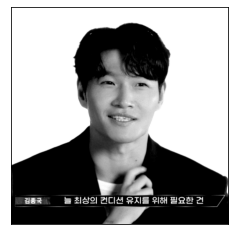

In [ ]:
# 이미지 불러오기
image = cv2.imread('sample.png')
#RGB 이미지를 BGR로 변환
imagee = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
# 이미지 출력
plt.imshow(imagee) 
plt.xticks([]) # x축 눈금 (빈칸으로 두어 아무것도 표기되지 않도록 함)
plt.yticks([]) # y축 눈금 (빈칸으로 두어 아무것도 표기되지 않도록 함)
plt.show() 

## 3) YOLOv4 Example on Test Image
 모델이 성공적으로 load되었는지 샘플 이미지에 test하여보자.

In [ ]:
# darknet_helper 함수에 앞서 읽은 이미지와 network height, width를 입력
detections, width_ratio, height_ratio = darknet_helper(imagee, width, height)

In [ ]:
# detection 결과 확인
detections, width_ratio, height_ratio

([('Opened_Eye',
   '84.03',
   (250.9087371826172,
    149.79258728027344,
    38.583045959472656,
    20.35283851623535)),
  ('Opened_Eye',
   '94.96',
   (185.71914672851562,
    147.3573760986328,
    39.64882278442383,
    13.868657112121582))],
 1.0,
 1.0)

* 튜플 형태 ("클래스 이름", class confidence, bounding box)로 결과가 저장된 것을 확인할 수 있다.
* bounding box로 나온 4가지 수치는 center x, center y, width, height에 해당한다. 

In [ ]:
width_ratio, height_ratio

(1.0, 1.0)

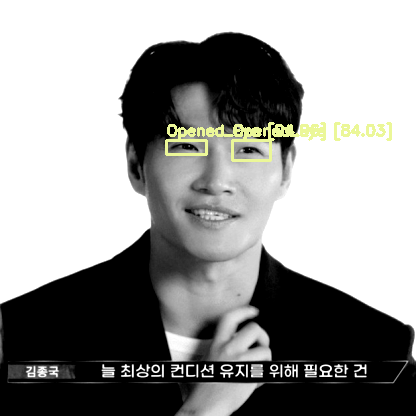

In [ ]:
# detection 결과 시각화

for label, confidence, bbox in detections:
  # center x, center y, width, height로 반환 받은 boundary box를 corner 정보 (left, top, right, bottom)로 변환
  left, top, right, bottom = bbox2points(bbox)
  # 앞서 계산한 이미지 비율을 사용하여 boundary box의 크기를 조정
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  # boundary box 좌표에 해당하는 사각형을 이미지 위에 그림
  cv2.rectangle(imagee, (left, top), (right, bottom), class_colors[label], 2)
  # 클래스 이름과 confidence level을 사각형 위에 입력
  cv2.putText(imagee, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)

# boundary box를 추가한 이미지 출력
#RGB 이미지를 BGR로 변환
image = cv2.cvtColor(imagee, cv2.COLOR_RGB2BGR)
cv2_imshow(image)

## 4) Helper Functions

다양한 타입의 사진을 처리할 수 있도록 사용하는 helper function들을 생성하여보자. 

* 웹캠을 구글 코랩에서 사용하기 위해서는 Javascript 코드를 실행하여야 한다. 따라서 OpenCV 파일을 Javascript 객체로 변환하고 그 반대로도 변환하는 함수를 생성하여 보자.
* 웹캠은 Javascript 코드를 사용하는 반면, bounding box는 OpenCV 형식이다.

`base64.b64decode(s, altchars=None, validate=False)`

* Base64로 인코딩된 바이트열류 객체나 ASCII 문자열 s를 디코딩하고 디코딩된 bytes를 반환한다.

In [ ]:
# JavaScript 객체를 OpenCV 이미지 유형으로 변환
def js_to_image(js_reply):
  """
  파라미터:
          js_reply: JavaScript 객체 (Base64 진법의 문자열)
  반환:
          img:  OpenCV BGR 이미지 (넘파이 배열로 이루어진 사각형 정보) 
  """

  # 64진법으로 인코딩된 Javascript 객체를 바이트로 디코딩 
  image_bytes = b64decode(js_reply.split(',')[1])
  # 바이트를 넘파이 배열로 변환
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # 넘파이 배열을 OpenCV BGR 이미지로 변환
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

`.save(fp, format=None)`
* PIL 형식의 이미지를 저장한다. 
* fp: 파일명/파일 주소/파일 객체
* format: 파일 저장 형식, 아무 입력이 없을 경우 파일명에 포함된 파일 형식으로 저장된다. fp에 파일명 대신 파일 객체가 입력되었을 경우 format 형식을 명시하는 것이 필수적이다. 

In [ ]:
# OpenCV 사각형(Bounding Box) 이미지를 JavaScript 객체로 변환
def bbox_to_bytes(bbox_array):
  """
  파라미터:
          bbox_array: OpenCV BGR 이미지 (넘파이 배열로 이루어진 사각형 정보) 
  반환:
        바이트: JavaScript 객체 (Base64 진법의 문자열)
  """
  # 넘파일 배열을 PIL(Python Image Library) 이미지로 변환 
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  # 문자열(바이트 배열)을 이진 파일로 읽을 수 있는 BytesIO 객체 생성
  iobuf = io.BytesIO()
  # PIL 이미지 형태의 boundary box를 png 파일로 변환하여 저장 
  bbox_PIL.save(iobuf, format='png')
  # JavaScript 객체 반환
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## YOLOv4 on Wecam Images

 웹캠으로 얻어진 이미지에 대하여 YOLO4을 적용하기 위하여, 구글 코랩에 있는 Code Snippets을 사용할 것이다. Code Snippets에는 다양한 작업을 위한 유용한 코드를 포함하고 있다.

 카메라 캡쳐 스니펫은 컴퓨터 웹캠을 사용하기 위한 자바스크립트 코드를 실행한다. 코드 스니펫은 웹캠 사진을 입력 받아 YOLOv4 model에 사진을 전달한다. 

`eval_js()`
* 자바 스크립트 함수를 실행한다.
* 이를 통해 파이썬 내부에서 바로 사용할 수 있다.

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):

  # 자바스크립트를 사용하여 local webcam에 access 
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // 결과를 resize
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // 클릭하여 이미지 캡쳐
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # YOLO v4 detection 수행

  # javascrip 이미지를 입력
  data = eval_js('takePhoto({})'.format(quality))
  # OpenCV 형식의 이미지로 변환
  img = js_to_image(data) 
  
  # 앞서 정의했던 darknet helper 함수에 웹캠 이미지를 삽입
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # detection을 통해 얻은 boundary boxes를 웹캠 이미지에 표시
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # 이미지를 저장
  cv2.imwrite(filename, img)

  return filename

* 허용 버튼을 클릭하면 웹캠 이미지와 캡쳐 버튼이 생성된다.

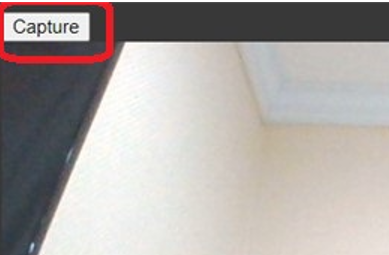

<IPython.core.display.Javascript object>

Saved to photo.jpg


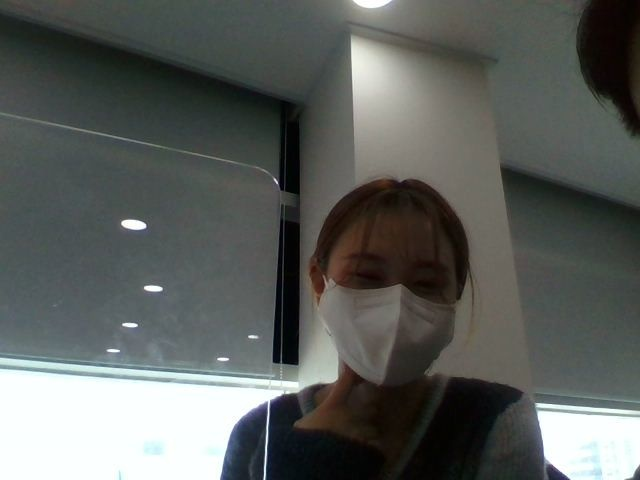

In [ ]:
try:
  # 앞서 정의한 take_photo 함수를 실행
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # take photo 결과물을 출력
  display(Image(filename))

  # 에러가 발행했을 실행
except Exception as err:
  # 사용자의 컴퓨터에 웹캠이 없거나 웹캠 접근권한이 없을 때 에러 메시지를 출력
  print(str(err))

아래는 영상 스트리밍을 실행하는 자바스크립트 코드이다. 영상의 프레임은 YOLOv4의 입력으로 주어지게 된다.

In [ ]:
# 실시간 영상 스트리밍을 작동시키는 JavaScript 코드
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Running on Webcam Video

In [ ]:
# 웹캠에서 영상 스트리밍을 시작
video_stream()
# label for video
label_html = 'Capturing...'
# bounding box 초기화 
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # javascript 객체를 OpenCV 이미지로 변환 
    frame = js_to_image(js_reply["img"])

    # bounding box를 위한 투명 overlay 생성
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # 앞서 정의하였던 darknet helper 함수를 실행 
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # detection 결과를 순회하며 결과를 overlay 이미지에 표시
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # bounding box의 overlay를 바이트로 변환
    bbox_bytes = bbox_to_bytes(bbox_array)
    # bounding box를 업데이트하여 다음 프레임이 새로운 overlay를 갖도록 함
    bbox = bbox_bytes

<IPython.core.display.Javascript object>